In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab import files

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.datasets import mnist
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.optimizers import Adam

Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)


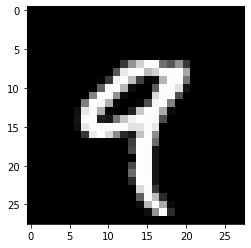

In [2]:
# Load MNIST Data
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape, x_test.shape)

plt.imshow(x_train[4], cmap='gray')
plt.show()

In [3]:
X_train = np.vstack((x_train, x_test))
print(X_train.shape)

# Normalize data to range [-1, 1]
X_train = (X_train.astype('float32') - 127.5) / 127.5
print(X_train.min(), X_train.max())

(70000, 28, 28)
-1.0 1.0


In [4]:
NOISE_DIM = 100  # Upsample this into 28x28 DIM image
adam = Adam(lr=1e-4, beta_1=0.5)

# Generator 
# Input- Noise(DIM 100) Output- Image(DIM 28x28)

generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(NOISE_DIM, )))
generator.add(Reshape((7, 7, 128)))
generator.add(LeakyReLU(0.2))

# Upsampling (14,14,128) + Convolution (14,14,64)
# generator.add(UpSampling2D())
# generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
generator.add(BatchNormalization())

# Upsampling (28,28,64) + Convolution (28,28,1)
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same'))

generator.compile(optimizer=adam, loss='binary_crossentropy')
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,193
Trainable params: 8

In [5]:
# Discriminator 
# Input- Image(DIM 784)  Output- Class(DIM 1)
discriminator = Sequential()

# Strided Convolution (No Max pooling)
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))

# Classifier
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(optimizer=adam, loss='binary_crossentropy')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [6]:
# GAN Training Step-2
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM, ))
gen_img = generator(gan_input)
gan_output = discriminator(gen_img)

model = Model(gan_input, gan_output)
model.compile(optimizer=adam, loss='binary_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         840193    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,058
Trainable params: 840,065
Non-trainable params: 212,993
_________________________________________________________________


In [7]:
!mkdir images

def save_images(epoch, samples = 100):
    noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))
    pred_imgs = generator.predict(noise)
    pred_imgs = pred_imgs.reshape((-1, 28, 28))
    
    plt.figure(figsize=(10, 10))
    for i in range(samples):
        plt.subplot(10, 10, i+1)
        plt.imshow(pred_imgs[i], cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig("images/gan_pred_imgs_{0}.png".format(epoch+1))
    plt.show()

mkdir: cannot create directory ‘images’: File exists


Epoch 1 - Dis. loss- 0.2760, Gen. Loss- 0.2760
Epoch 2 - Dis. loss- 0.7107, Gen. Loss- 0.7107
Epoch 3 - Dis. loss- 0.5763, Gen. Loss- 0.5763
Epoch 4 - Dis. loss- 0.5592, Gen. Loss- 0.5592
Epoch 5 - Dis. loss- 0.5031, Gen. Loss- 0.5031


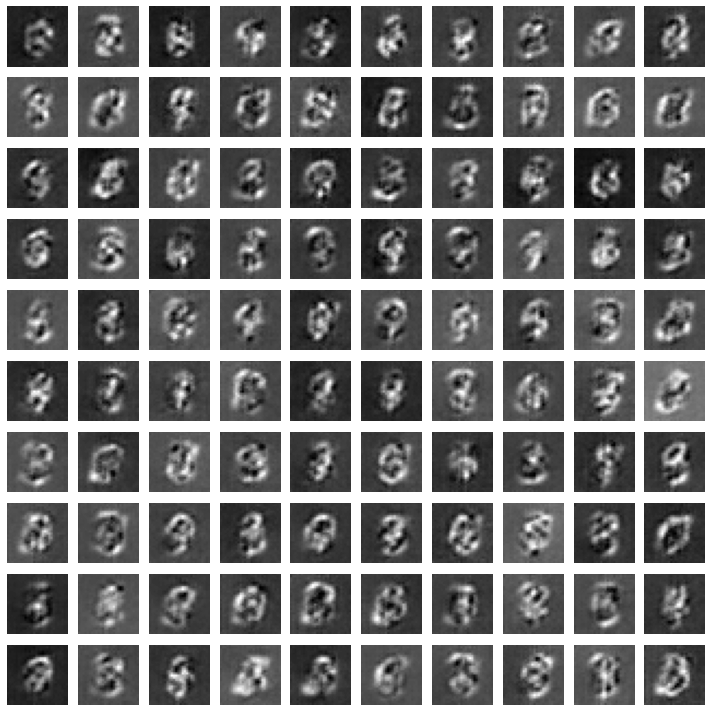

Epoch 6 - Dis. loss- 0.4486, Gen. Loss- 0.4486
Epoch 7 - Dis. loss- 0.4004, Gen. Loss- 0.4004
Epoch 8 - Dis. loss- 0.3662, Gen. Loss- 0.3662
Epoch 9 - Dis. loss- 0.3450, Gen. Loss- 0.3450
Epoch 10 - Dis. loss- 0.3261, Gen. Loss- 0.3261


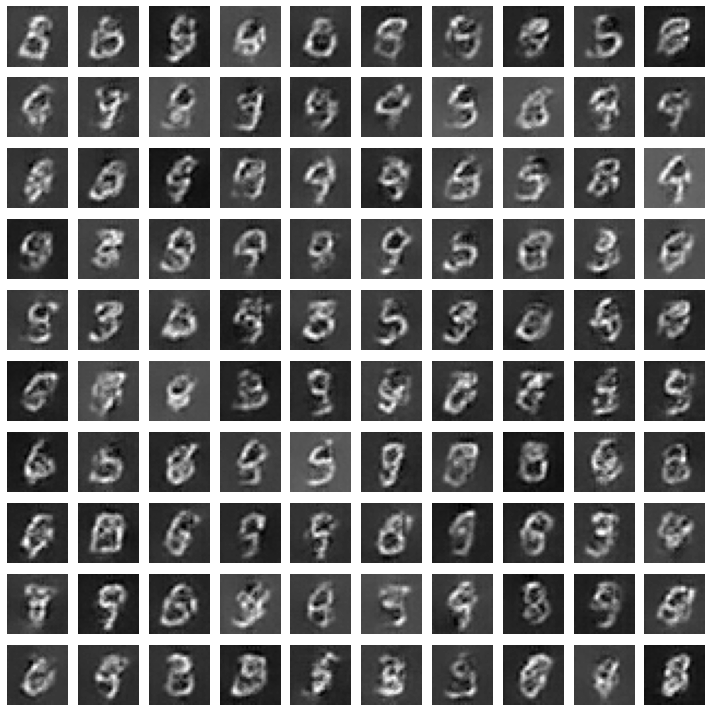

Epoch 11 - Dis. loss- 0.3150, Gen. Loss- 0.3150
Epoch 12 - Dis. loss- 0.3137, Gen. Loss- 0.3137
Epoch 13 - Dis. loss- 0.3052, Gen. Loss- 0.3052
Epoch 14 - Dis. loss- 0.3011, Gen. Loss- 0.3011
Epoch 15 - Dis. loss- 0.3008, Gen. Loss- 0.3008


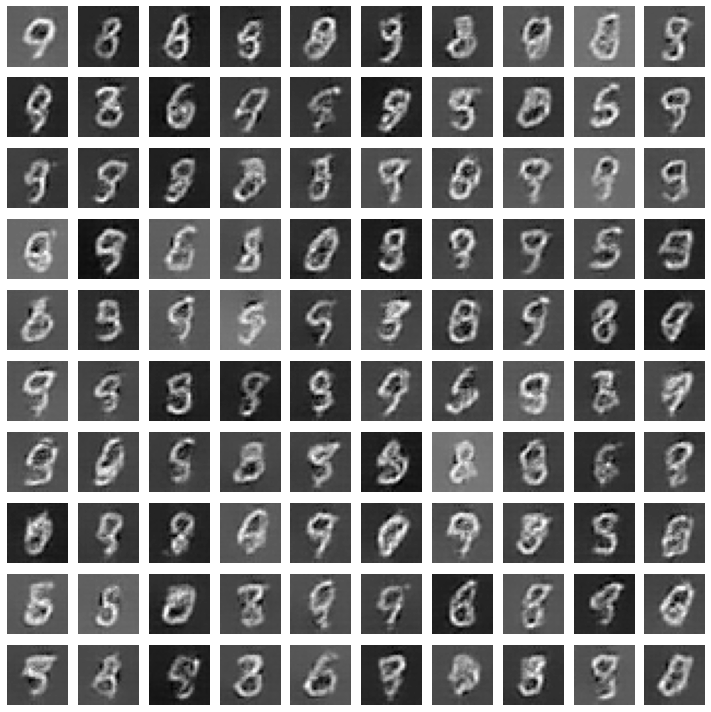

Epoch 16 - Dis. loss- 0.2981, Gen. Loss- 0.2981
Epoch 17 - Dis. loss- 0.2970, Gen. Loss- 0.2970
Epoch 18 - Dis. loss- 0.2939, Gen. Loss- 0.2939
Epoch 19 - Dis. loss- 0.2939, Gen. Loss- 0.2939
Epoch 20 - Dis. loss- 0.2903, Gen. Loss- 0.2903


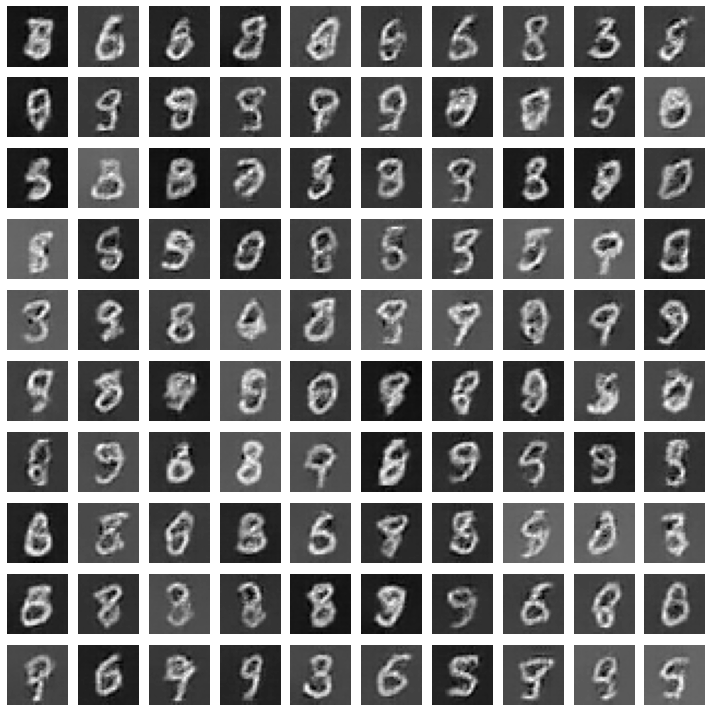

Epoch 21 - Dis. loss- 0.2902, Gen. Loss- 0.2902
Epoch 22 - Dis. loss- 0.2914, Gen. Loss- 0.2914
Epoch 23 - Dis. loss- 0.2888, Gen. Loss- 0.2888
Epoch 24 - Dis. loss- 0.2852, Gen. Loss- 0.2852
Epoch 25 - Dis. loss- 0.2849, Gen. Loss- 0.2849


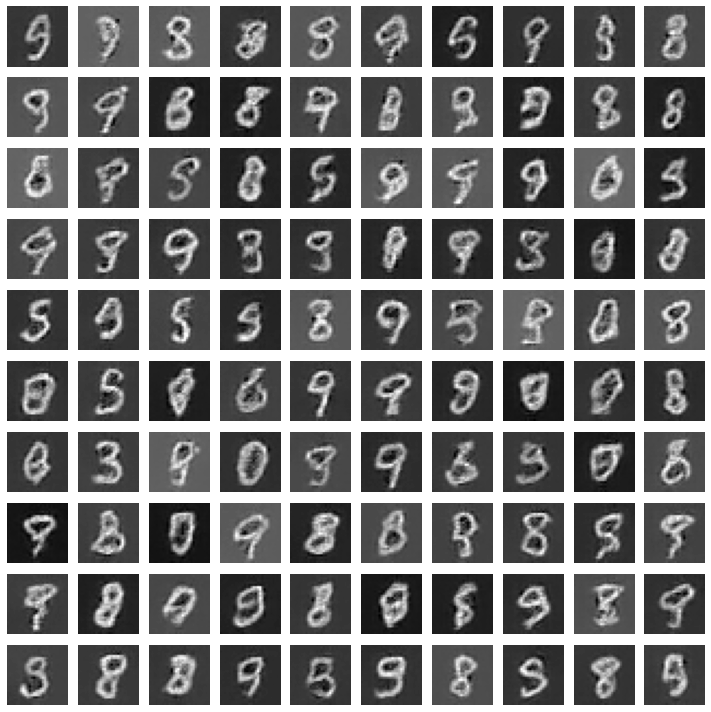

Epoch 26 - Dis. loss- 0.2828, Gen. Loss- 0.2828
Epoch 27 - Dis. loss- 0.2815, Gen. Loss- 0.2815
Epoch 28 - Dis. loss- 0.2839, Gen. Loss- 0.2839
Epoch 29 - Dis. loss- 0.2799, Gen. Loss- 0.2799
Epoch 30 - Dis. loss- 0.2810, Gen. Loss- 0.2810


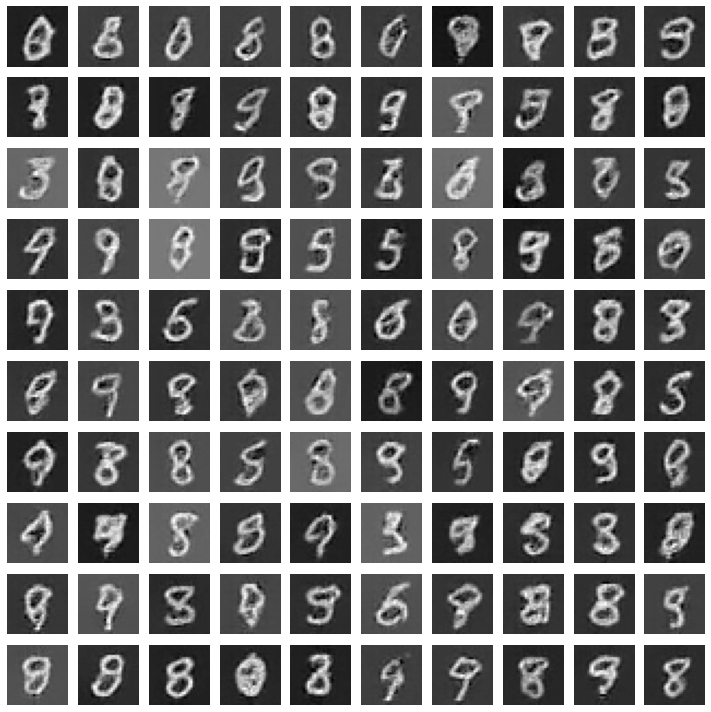

Epoch 31 - Dis. loss- 0.2791, Gen. Loss- 0.2791
Epoch 32 - Dis. loss- 0.2778, Gen. Loss- 0.2778
Epoch 33 - Dis. loss- 0.2725, Gen. Loss- 0.2725
Epoch 34 - Dis. loss- 0.2787, Gen. Loss- 0.2787
Epoch 35 - Dis. loss- 0.2741, Gen. Loss- 0.2741


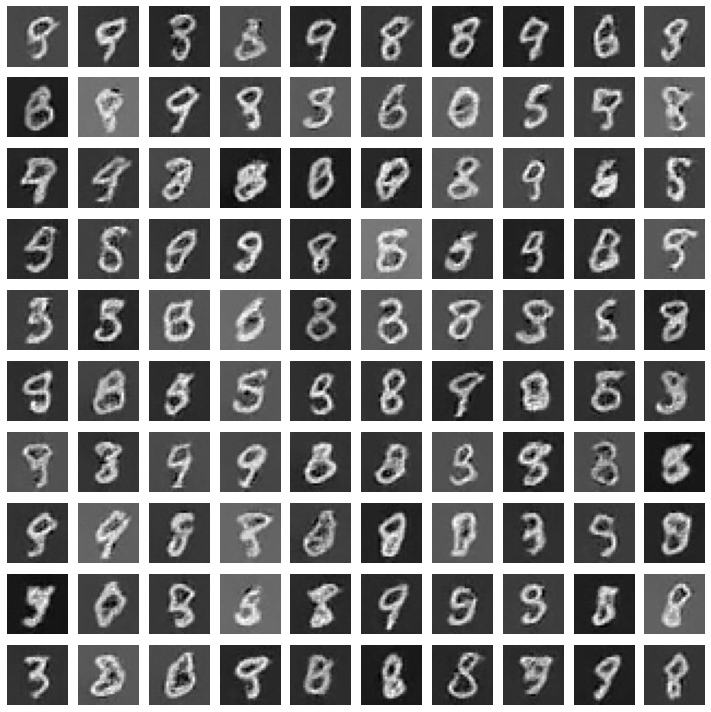

Epoch 36 - Dis. loss- 0.2735, Gen. Loss- 0.2735
Epoch 37 - Dis. loss- 0.2705, Gen. Loss- 0.2705
Epoch 38 - Dis. loss- 0.2696, Gen. Loss- 0.2696
Epoch 39 - Dis. loss- 0.2711, Gen. Loss- 0.2711
Epoch 40 - Dis. loss- 0.2693, Gen. Loss- 0.2693


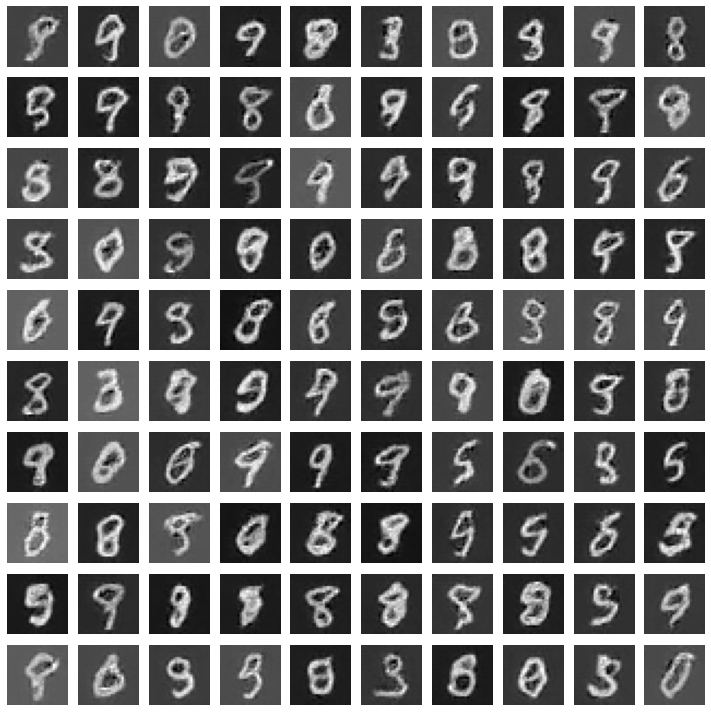

Epoch 41 - Dis. loss- 0.2662, Gen. Loss- 0.2662
Epoch 42 - Dis. loss- 0.2660, Gen. Loss- 0.2660
Epoch 43 - Dis. loss- 0.2661, Gen. Loss- 0.2661
Epoch 44 - Dis. loss- 0.2681, Gen. Loss- 0.2681
Epoch 45 - Dis. loss- 0.2649, Gen. Loss- 0.2649


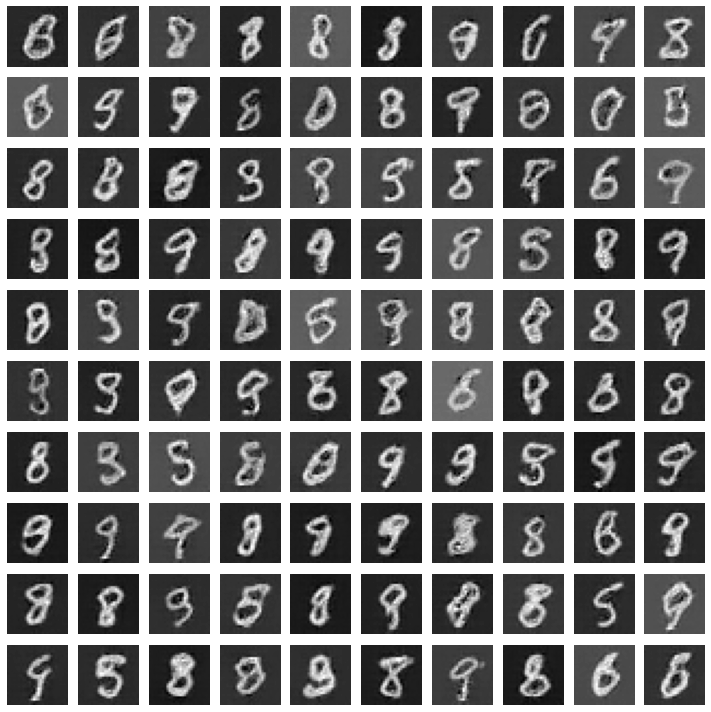

Epoch 46 - Dis. loss- 0.2616, Gen. Loss- 0.2616
Epoch 47 - Dis. loss- 0.2671, Gen. Loss- 0.2671
Epoch 48 - Dis. loss- 0.2645, Gen. Loss- 0.2645
Epoch 49 - Dis. loss- 0.2602, Gen. Loss- 0.2602
Epoch 50 - Dis. loss- 0.2615, Gen. Loss- 0.2615


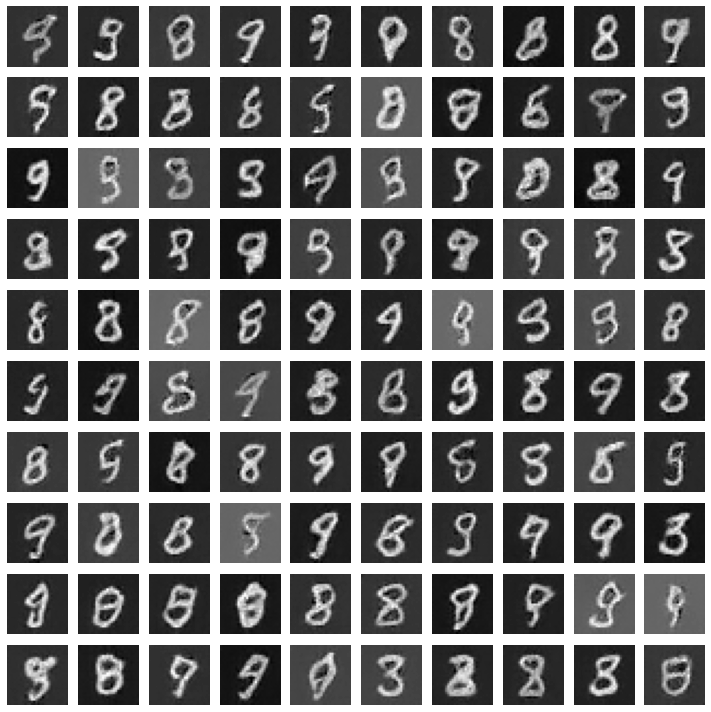

In [8]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
HALF_BATCH = 128
NO_OF_BATCHES = int(X_train.shape[0] / BATCH_SIZE)

# Training loop
dis_loss = []
gen_loss = []

X_train = X_train.reshape((-1, 28, 28, 1))
for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    # Mini batch SGD
    for step in range(NO_OF_BATCHES):
        # Step-1 Discriminator training
        # 50% Real data + 50% Fake data
        
        # Real data X
        idxs = np.random.randint(0, X_train.shape[0], HALF_BATCH)
        real_imgs = X_train[idxs]
        
        # Fake data X
        noise = np.random.normal(0, 1, size=(HALF_BATCH, NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        # Labels
        real_y = np.ones((HALF_BATCH, 1)) * 0.9  # One sided label smoothing
        fake_y = np.zeros((HALF_BATCH, 1))
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        epoch_d_loss += 0.5*d_loss_real + 0.5*d_loss_fake
        
        # Generator Training (considering Frozen Discriminator)
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE, 1))
        g_loss = model.train_on_batch(noise, ground_truth_y)
        epoch_g_loss += g_loss
        
    dis_loss.append(epoch_d_loss/NO_OF_BATCHES)
    gen_loss.append(epoch_g_loss/NO_OF_BATCHES)
    
    print("Epoch %d - Dis. loss- %.4f, Gen. Loss- %.4f"%(
        (epoch+1), epoch_d_loss/NO_OF_BATCHES, epoch_d_loss/NO_OF_BATCHES))
    
    if ((epoch+1)%5) == 0:
        generator.save('model_gan_gen_{0}.h5'.format(epoch+1))
        save_images(epoch)

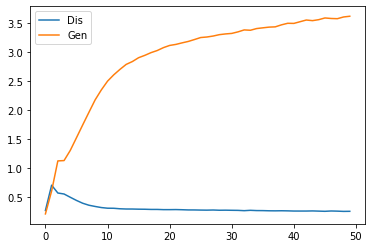

In [9]:
# Plot Losses
plt.plot(dis_loss, label='Dis')
plt.plot(gen_loss, label='Gen')
plt.legend()
plt.show()

In [10]:
!zip -r /content/images.zip /content/images
files.download('images.zip')

updating: content/images/ (stored 0%)
updating: content/images/gan_pred_imgs_35.png (deflated 3%)
updating: content/images/gan_pred_imgs_15.png (deflated 2%)
updating: content/images/gan_pred_imgs_40.png (deflated 3%)
updating: content/images/gan_pred_imgs_20.png (deflated 2%)
updating: content/images/gan_pred_imgs_50.png (deflated 3%)
updating: content/images/gan_pred_imgs_5.png (deflated 2%)
updating: content/images/gan_pred_imgs_25.png (deflated 2%)
updating: content/images/gan_pred_imgs_10.png (deflated 2%)
updating: content/images/gan_pred_imgs_30.png (deflated 2%)
updating: content/images/gan_pred_imgs_45.png (deflated 3%)
